## Goals: Feature Engineering

This notebook merge _Brazil_ and _France_ dataset into a single training dataset.
It adds seasonal information (seasons, month), scale relevent features and removed unecessary columns.

> Note this notebook need ouputs from both _01a - Data Preprocessing Brazil_ and 01b - _Data Preprocessing France_

![Alt text](../images/notebook-2.png)

### 1. Data Import and Setup

Imports necessary libraries, sets up environment paths, and includes custom utility functions.


In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(BASE_DIR)

from src.utils.plots import plot_water_flows

Defines constants :

- INPUT*DIR must be the same as the one defined in \_01 - Data Preprocessing* notebook.
- EVAL*DIR must be the same as the one defined in \_01 - Data Preprocessing* notebook.


In [6]:
INPUT_DIR = "../../../data/input/"
EVAL_DIR = "../../../data/evaluation/"

DATASET_SPEC = "soil_pca"

datasets = {"train": INPUT_DIR, "eval": EVAL_DIR}

### 2. Data Loading and Initial Cleaning

- Reads in the French and Brazilian baseline datasets, removes unnecessary columns, and sets the date as the index.
- Introduces a binary indicator (`north_hemisphere`) to distinguish between data from France and Brazil.
- Merges the French and Brazilian datasets into a single DataFrame for further processing.


In [7]:
dataset_baseline = {}

for set, dir in datasets.items():
    path_data_baseline_france = f"{dir}preprocessed_france.csv"
    dataset_baseline_france = pd.read_csv(path_data_baseline_france)

    dataset_baseline_france = dataset_baseline_france.iloc[:, 1:]
    dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])

    dataset_baseline_france = dataset_baseline_france.set_index("ObsDate")

    path_data_baseline = f"{dir}preprocessed_brazil.csv"
    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:, 1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = dataset_baseline_brazil.set_index("ObsDate")

    dataset_baseline_france["north_hemisphere"] = 1
    dataset_baseline_brazil["north_hemisphere"] = 0

    dataset_baseline[set] = pd.concat(
        [dataset_baseline_france, dataset_baseline_brazil], axis=0
    )

### 3. Feature Engineering

Creates seasonal and monthly indicator columns.


In [8]:
for set, dir in datasets.items():
    # Convert the index to datetime and extract the month
    month = pd.to_datetime(dataset_baseline[set].index).month

    # Define season mappings
    seasons = {
        "is_winter": [1, 2, 3],
        "is_spring": [4, 5, 6],
        "is_summer": [7, 8, 9],
        "is_autumn": [10, 11, 12],
    }

    # Apply season flags
    for season, months in seasons.items():
        dataset_baseline[set][season] = month.isin(months)

    # Define month abbreviations and apply monthly flags
    months_abbr = [
        "jan",
        "feb",
        "mar",
        "apr",
        "may",
        "jun",
        "jul",
        "aug",
        "sep",
        "oct",
        "nov",
        "dec",
    ]
    for i, abbr in enumerate(months_abbr, start=1):
        dataset_baseline[set][f"is_{abbr}"] = month == i

Applies MinMax scaling to the selected features.


In [9]:
for set, dir in datasets.items():
    scaler = MinMaxScaler()
    cols = dataset_baseline[set].columns
    # remove the water_flows columns
    if set == "eval":
        cols = cols.drop(["station_code", "water_flow_lag_1w", "water_flow_lag_2w"])
    elif set == "train":
        cols = cols.drop(
            [
                "water_flow_week1",
                "station_code",
                "water_flow_week2",
                "water_flow_week3",
                "water_flow_week4",
                "water_flow_lag_1w",
            ]
        )
    dataset_baseline[set][cols] = scaler.fit_transform(dataset_baseline[set][cols])

### 4. Handling Missing Data

Removes undesired columns, identifies columns with missing values, and imputes them with their respective column means.


In [10]:
# remove columns that start with index_
for set, dir in datasets.items():
    cols = dataset_baseline[set].columns
    cols = cols[~cols.str.startswith("index_")]
    dataset_baseline[set] = dataset_baseline[set][cols]

    # find columns that contains nan values

    cols_nan = (
        dataset_baseline[set].columns[dataset_baseline[set].isna().any()].tolist()
    )

    # impute nan values with the mean
    for col in cols_nan:
        dataset_baseline[set][col] = dataset_baseline[set][col].fillna(
            dataset_baseline[set][col].mean()
        )

### 4.1 Adding SnowIndex


In [11]:
class SnowIndexComputeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, altitude_weight=0.6, temp_weight=0.3, precip_weight=0.7):
        self.altitude_weight = altitude_weight
        self.temp_weight = temp_weight
        self.precip_weight = precip_weight

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        required_columns = ["altitude", "temperatures", "precipitations"]
        if not all(col in X.columns for col in required_columns):
            raise ValueError(
                f"DataFrame must contain following columns : {required_columns}"
            )

        snow_index = (
            (X["altitude"] * self.altitude_weight)
            * (X["precipitations"] * self.precip_weight)
            / (X["temperatures"] * self.temp_weight)
        )

        snow_index.replace([np.inf, -np.inf], np.nan, inplace=True)
        snow_index.fillna(0, inplace=True)

        # Normalise SnowIndex between 0 and 1
        snow_index = (snow_index - snow_index.min()) / (
            snow_index.max() - snow_index.min()
        )

        X_transformed = X.copy()
        X_transformed["snow_index"] = snow_index

        return X_transformed

In [12]:
transformer = SnowIndexComputeTransformer()
dataset_baseline["train"] = transformer.fit_transform(dataset_baseline["train"])
dataset_baseline["eval"] = transformer.fit_transform(dataset_baseline["eval"])
print(dataset_baseline["train"]["snow_index"].min())
print(dataset_baseline["train"]["snow_index"].max())

0.0
1.0


In [ ]:
print(dataset_baseline["train"].shape)
print(dataset_baseline["eval"].shape)

(28431, 160)
(1352, 156)


### **4.2 Data aggregation on temporal data through scope**


### 4.2.1 Executing PCA strategy on soil composition


In [ ]:
from sklearn.decomposition import PCA

soil_composition_keys = [
    f"{var}_{depth}_mean_index__{scope}"
    for var in ["sand", "bdod", "cfvo", "clay"]
    for depth in ["0-5cm", "5-15cm", "15-30cm", "30-60cm", "60-100cm", "100-200cm"]
    for scope in ["region", "zone", "sector", "sub_sector"]
]

print(f"Original train dataset shape {dataset_baseline['train'].shape}")
print(f"Original eval dataset shape {dataset_baseline['eval'].shape}")

for set, dir in datasets.items():
    print(f"Processing {set} dataset")

    original_index = dataset_baseline[set][soil_composition_keys].index

    pca = PCA(n_components=10)
    pca_data = pca.fit_transform(dataset_baseline[set][soil_composition_keys])

    pca_df = pd.DataFrame(pca_data, index=original_index)

    pca_df.columns = [f"soil_pca_{i+1}" for i in range(pca_df.shape[1])]

    dataset_baseline[set] = pd.concat([dataset_baseline[set], pca_df], axis=1)
    dataset_baseline[set] = dataset_baseline[set].drop(columns=soil_composition_keys)

print(f"Final train dataset shape {dataset_baseline['train'].shape}")
print(f"Final eval dataset shape {dataset_baseline['eval'].shape}")

Original train dataset shape (28431, 160)
Original eval dataset shape (1352, 156)
Processing train dataset
Processing eval dataset
Final train dataset shape (28431, 74)
Final eval dataset shape (1352, 70)


#### 4.2.2 soil moisture aggregation


#### 4.2.3 evaporation aggregation


#### 4.2.4 Overal aggregation by scope


#### 4.3 Sine and Cosine month encoding


In [35]:
def convert_one_hot_to_label(df, columns, column_name):
    df[column_name] = np.argmax(df[columns].values, axis=1) + 1
    df = df.drop(columns=columns)
    return df


def encode_cyclical(df, column, max_val, drop_original=True):
    df[f"{column}_sin"] = np.sin(2 * np.pi * df[column] / max_val)
    df[f"{column}_cos"] = np.cos(2 * np.pi * df[column] / max_val)

    if drop_original:
        df = df.drop(columns=[column])
    return df

##### 4.3.1 Converting on-hot to index encoding


In [ ]:
# List of month column names
month_cols = [
    "is_jan",
    "is_feb",
    "is_mar",
    "is_apr",
    "is_may",
    "is_jun",
    "is_jul",
    "is_aug",
    "is_sep",
    "is_oct",
    "is_nov",
    "is_dec",
]

dataset_baseline["train"] = convert_one_hot_to_label(
    dataset_baseline["train"], month_cols, "month"
)
dataset_baseline["eval"] = convert_one_hot_to_label(
    dataset_baseline["eval"], month_cols, "month"
)

In [26]:
seasons_cols = ["is_winter", "is_spring", "is_summer", "is_autumn"]

dataset_baseline["train"] = convert_one_hot_to_label(
    dataset_baseline["train"], seasons_cols, "season"
)
dataset_baseline["eval"] = convert_one_hot_to_label(
    dataset_baseline["eval"], seasons_cols, "season"
)

##### 4.3.2 Converting index encoding to Cyclical encoding


In [36]:
dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "month", 12)
dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "month", 12)

In [37]:
dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "season", 4)
dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "season", 4)

### 5. Data Saving, and Visualization


Saves the complete baseline.


In [15]:
for set, dir in datasets.items():
    dataset_baseline[set].to_csv(f"{dir}dataset_{DATASET_SPEC}.csv")

Visualizes the water flow for the 10 first stations.


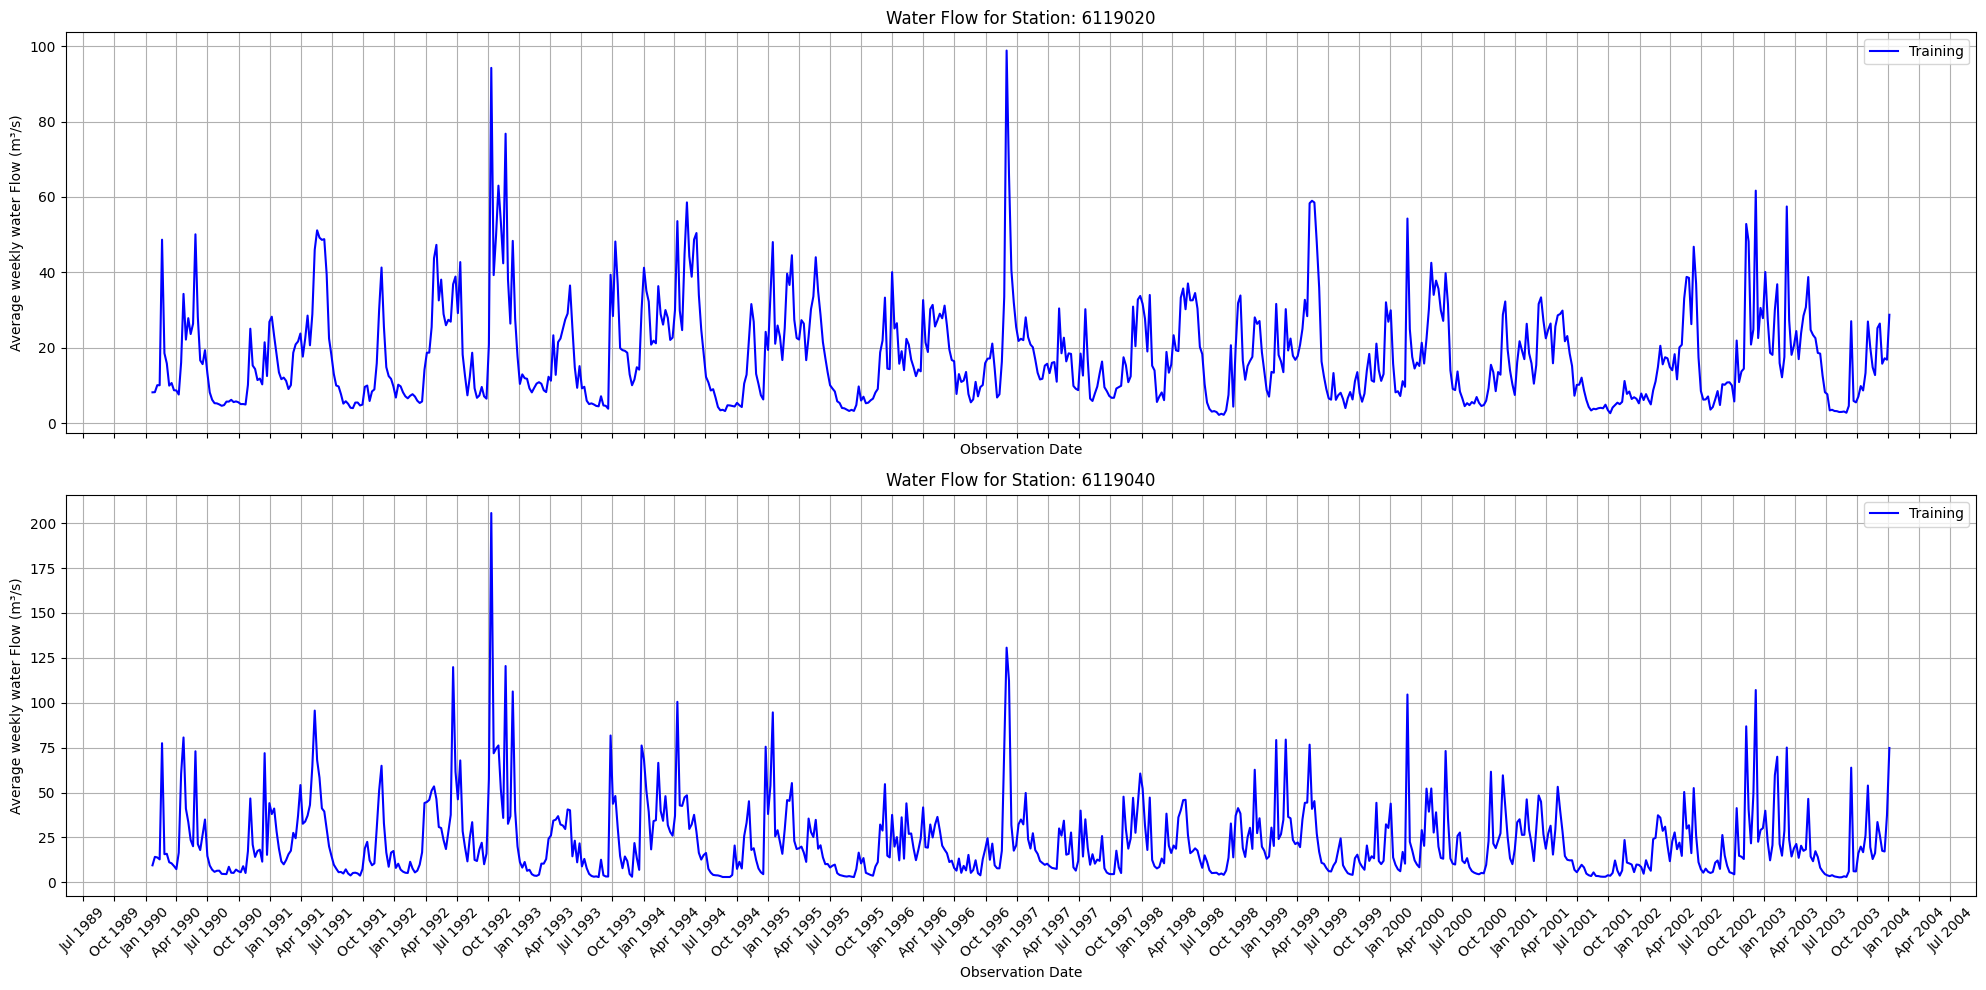

In [16]:
plot_water_flows(dataset_baseline["train"], max_stations=2, display=True, save=False)